In [83]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, os, torch, math, torchvision, datetime
from tqdm.notebook import tqdm 
import torch.nn.functional as F

# my files
from cmgraph import parse_gcs, image_to_world, GCSDatasetLoaderStatic
from models import DenseGCNGRU, GRU_only, GCNGRU, A3TGCN_2, TGCN_2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
%%time
trajs= parse_gcs("GCS/Annotation")

0it [00:00, ?it/s]

CPU times: user 39.2 s, sys: 4.65 s, total: 43.9 s
Wall time: 43.1 s


/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
# display annotation data
df = pd.concat(trajs)
df.head()

,index,frame_id,agent_id,pos_x,pos_y,img_x,img_y,timestamp,vel_x,vel_y
0,0,0,1,39.531444,16.780638,122.0,525.0,0.0,-0.834921,1.868034
1,1,20,1,38.863508,18.275066,141.0,541.0,0.8,-0.834921,1.868034
2,2,40,1,38.562653,19.421289,156.0,546.0,1.6,-0.376068,1.432779
3,3,60,1,38.185597,20.377113,169.0,555.0,2.4,-0.471320,1.194780
4,4,80,1,37.888498,21.381171,183.0,561.0,3.2,-0.371374,1.255072


In [13]:
# 7 egress zones. each zone (x1, y1, x2, y2)
ZONE_LIST =[
    (0, 0, 28, 14),
    (28, 0, 55, 14),
    (0, 14, 28, 24),
    (28, 14, 55, 24),
    (0, 24, 28, 35),
    (28, 24, 55, 35),
    (0, 35, 28, 45),
    (28, 35, 55, 45),
    (0, 45, 55, 55)
]
loader = GCSDatasetLoaderStatic(
    trajs=trajs,
    ZONE_LIST = ZONE_LIST)

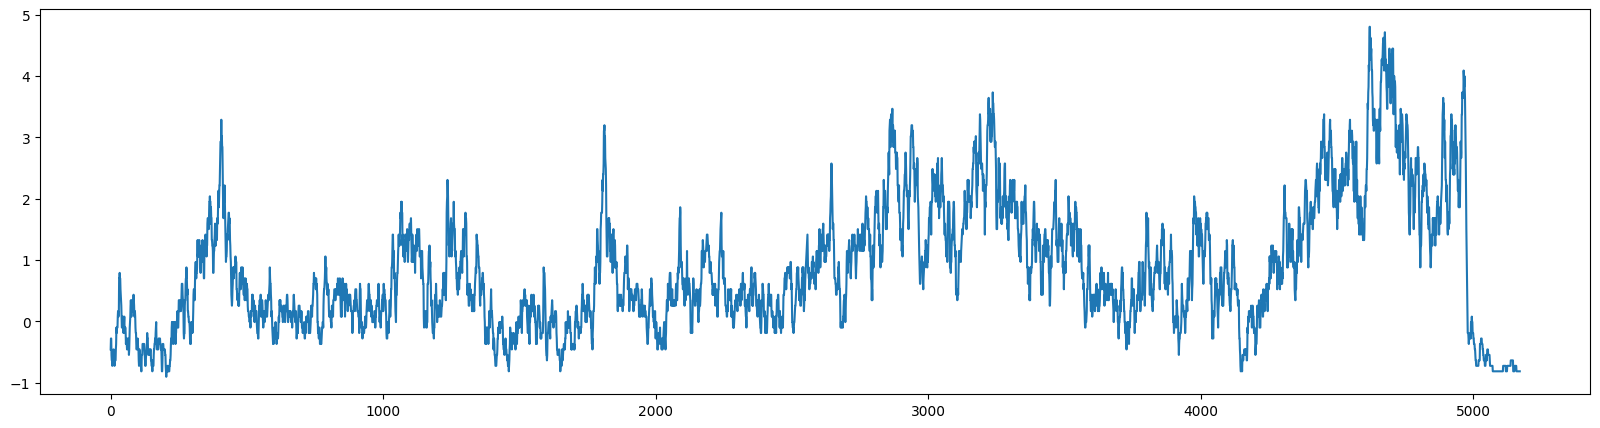

In [15]:
# Visualize traffic over time
plt.figure(figsize=(20,5))
zone_number = 8
time = -1
zone_labels = [bucket.y[zone_number][0].item() for bucket in list(dataset)[:time]]
plt.plot(zone_labels)

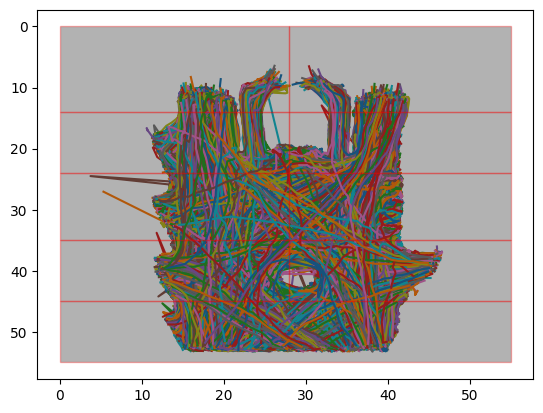

In [26]:
# Visualize zones and trajectories
from matplotlib.patches import Rectangle
plt.gca().invert_yaxis()
for traj in trajs: 
    plt.plot(traj['pos_x'],traj['pos_y'],zorder=0)
    
ax = plt.gca()
for i,(x1,y1,x2,y2) in enumerate(ZONE_LIST): 
    rect = Rectangle((x1,y1),
                     x2-x1, 
                     y2-y1, 
                     alpha=0.3,
                     facecolor=(0,0,0),
                     edgecolor='r',
                    )
    ax.add_patch(rect)

# Construct CMGraph Given Egress Region Definitions

In [14]:
dataset = loader.get_dataset(num_timesteps_in=20, num_timesteps_out=20)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(list(dataset)))
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7faa9aaafb80>
Number of samples / sequences:  5173
Data(x=[9, 2, 20], edge_index=[2, 36], edge_attr=[36], y=[9, 20])


In [28]:
batch_size = 32

input_np = np.array(dataset.features) 
target_np = np.array(dataset.targets) 
input_tensor = torch.from_numpy(input_np).type(torch.FloatTensor).to(device)  # (B, N, F, T)
target_tensor = torch.from_numpy(target_np).type(torch.FloatTensor).to(device)  # (B, N, T)
dataset_new = torch.utils.data.TensorDataset(input_tensor, target_tensor)

proportions = [0.7,0.3]
lengths = [int(p * len(dataset_new)) for p in proportions]
lengths[-1] = len(dataset_new) - sum(lengths[:-1])
train_dataset_new, test_dataset_new = torch.utils.data.random_split(dataset_new, lengths, generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False)

print("Number of train buckets: ", len(list(train_dataset_new)))
print("Number of test buckets: ", len(list(test_dataset_new)))

Number of train buckets:  3621
Number of test buckets:  1552


In [89]:
%%time
'''
Select desired model here.
''' 
# model = GRU_only(in_channels=2, periods=20, batch_size=batch_size).to(device)
# model = GCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(device)
model = DenseGCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(device)
# model = A3TGCN_2(node_features=2, periods=20, batch_size=batch_size).to(device)
# model = TGCN_2(node_features=2, periods=20, batch_size=batch_size).to(device)

loss_fn = torch.nn.MSELoss()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(device)
    break;
    
# start training loop 
for epoch in range(40):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print("Epoch {} Step {} train MSE: {:.4f}".format(epoch, step, sum(loss_list)/len(loss_list)))
        step= step+ 1

Epoch 0 Step 0 train MSE: 0.7777
Epoch 0 Step 100 train MSE: 0.2719
Epoch 1 Step 0 train MSE: 0.1286
Epoch 1 Step 100 train MSE: 0.1257
Epoch 2 Step 0 train MSE: 0.0933
Epoch 2 Step 100 train MSE: 0.1203
Epoch 3 Step 0 train MSE: 0.1147
Epoch 3 Step 100 train MSE: 0.1140
Epoch 4 Step 0 train MSE: 0.1216
Epoch 4 Step 100 train MSE: 0.1117
Epoch 5 Step 0 train MSE: 0.1308
Epoch 5 Step 100 train MSE: 0.1100
Epoch 6 Step 0 train MSE: 0.1230
Epoch 6 Step 100 train MSE: 0.1104
Epoch 7 Step 0 train MSE: 0.1006
Epoch 7 Step 100 train MSE: 0.1088
Epoch 8 Step 0 train MSE: 0.1178
Epoch 8 Step 100 train MSE: 0.1069
Epoch 9 Step 0 train MSE: 0.1000
Epoch 9 Step 100 train MSE: 0.1055
Epoch 10 Step 0 train MSE: 0.1549
Epoch 10 Step 100 train MSE: 0.1045
Epoch 11 Step 0 train MSE: 0.0869
Epoch 11 Step 100 train MSE: 0.1034
Epoch 12 Step 0 train MSE: 0.0884
Epoch 12 Step 100 train MSE: 0.1035
Epoch 13 Step 0 train MSE: 0.1121
Epoch 13 Step 100 train MSE: 0.1031
Epoch 14 Step 0 train MSE: 0.0948
Epoch 

In [96]:
%%time
# testing loop 
loss_fn = torch.nn.MSELoss()
torch.no_grad()
model.eval()
# Store for analysis
total_loss = []
total_mae = []
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(device)
    break;
    
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    mae = F.l1_loss(y_hat, labels)
    total_loss.append(loss.item())
    total_mae.append(mae.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    
print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))
print("Test MAE: {:.4f}".format(sum(total_mae)/len(total_mae)))
print(y_hat.shape)

Test MSE: 0.0955
Test MAE: 0.2200
torch.Size([16, 9, 20])
CPU times: user 4.15 s, sys: 8.2 ms, total: 4.16 s
Wall time: 660 ms


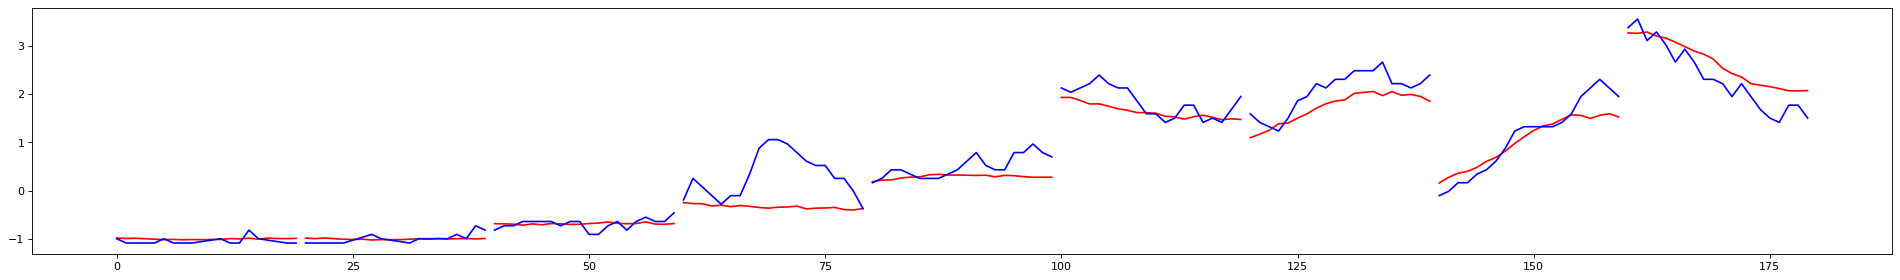

In [91]:
# visualize each egress region's crowd from one example sequence
from matplotlib.pyplot import figure
sample_output = y_hat[15]
sample_labels = labels[15] # (9, 20)
figure(figsize=(30,4), dpi=80)
for i in range(len(ZONE_LIST)):
    new_i = i * 20
    plt.plot(range(0+new_i,20+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,20+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()

# Saving and loading model checkpoints

In [93]:

filename = 'checkpoints/'+model.__class__.__name__+'.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': sum(loss_list)/len(loss_list),
            }, filename)
filename

'checkpoints/DenseGCNGRU.pt'

In [95]:
# load checkpoint
model = DenseGCNGRU(in_channels=2, periods=20, batch_size=batch_size).to(device)
checkpoint = torch.load('checkpoints/DenseGCNGRU.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(model)

model.train()
sum(p.numel() for p in model.parameters() if p.requires_grad)

DenseGCNGRU(
  (densegcn): DeepGCNLayer(block=dense)
  (gru): GRU(130, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=20, bias=True)
)


97300